# Credit Card Fraud - Anomaly detection

This notebook explores the use of random undersampling to balance skewed data classes. Dimensionality reduction using t-SNE, autoenconding neural networks, and PCA are used to separate and visualize the data in two dimensions. This is followed by the implementation of a logistic regression classifier.

Later I will add in sections where I use Keras to fit models of over- and undersampled data.

## Acknowledgements

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project.

In [3]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import itertools

from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#from imblearn.under_sampling import RandomUnderSampler

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    warnings.filterwarnings("ignore",category=FutureWarning)

# Data Exploration

### Load Data

In [2]:
# load and preview dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Check for missing values

Total NaN values in dataframe: 0


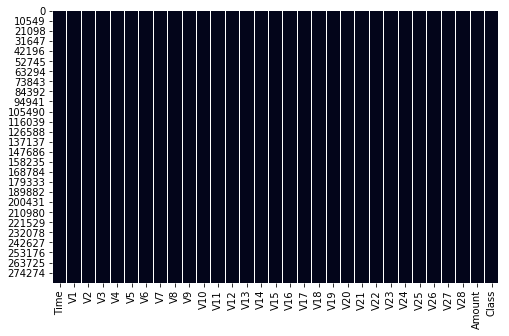

In [4]:
# check for NaN values
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(df.isnull(), cbar=False, ax=ax)
print('Total NaN values in dataframe: {}'.format(df.isnull().sum().sum()))

### Normalize Features

In [5]:
# look at value ranges in case data needs to be normalized
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# normalize 'Time' and 'Amount'; V-features are all in range ~[-5,5]
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

df = df.drop(['Time', 'Amount'], axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


### Feature distributions

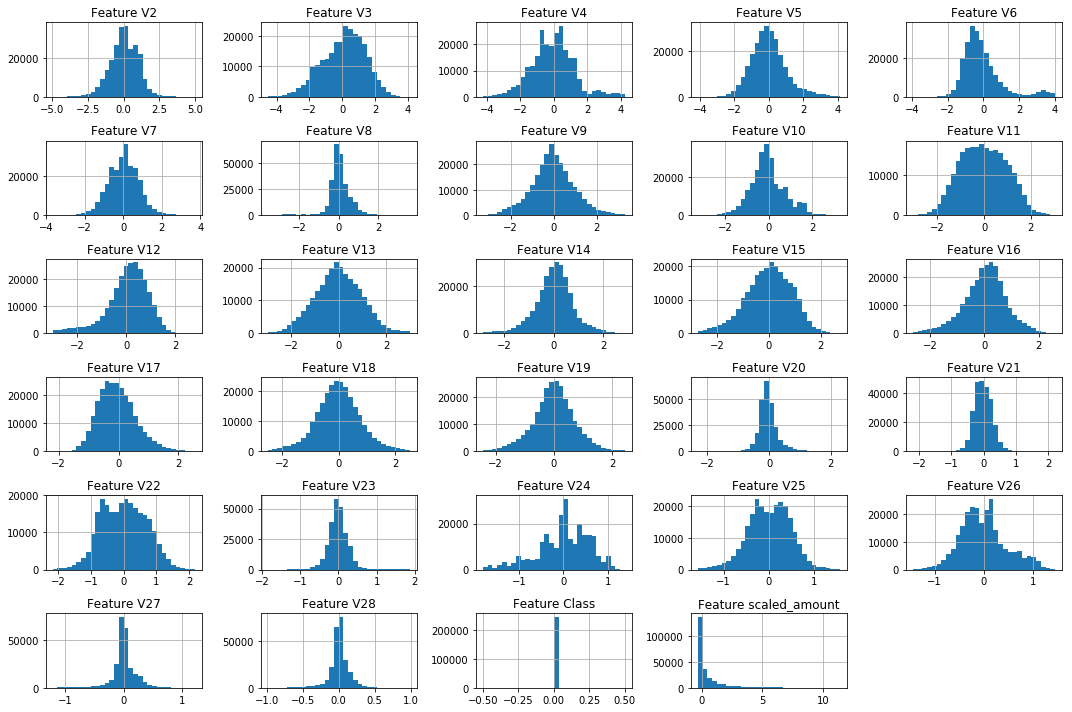

In [7]:
# now look at distributions of the features with outliers removed

df_no_outliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

def df_hist_grid(df, cols, n_rows, n_cols, figsize_x=10, figsize_y=8):
    fig = plt.figure(figsize=(figsize_x, figsize_y))
    for i, col in enumerate(cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        #df[col].hist(bins=30, ax=ax)
        df_no_outliers[col].hist(bins=30, ax=ax)
        ax.set_title('Feature ' + col)
    fig.tight_layout()
    plt.show()

df_hist_grid(df, df.columns[1:-1], 6, 5, 15, 10)

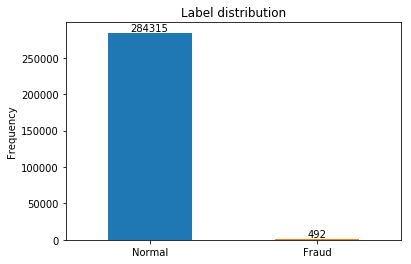

In [8]:
# let's look at the distribution of pass/fail labels

colors = sns.color_palette()
palette = itertools.cycle(colors)

def df_count_classes_plot(df):
    label_counts = pd.value_counts(df['Class'], sort = True)
    ax = label_counts.plot(kind = 'bar',color=[colors[0], colors[1]], rot=0)
    plt.title('Label distribution')
    plt.xticks(range(2), ['Normal', 'Fraud'])
    plt.ylabel('Frequency')

    # add values to plot
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2),
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='center', 
                    xytext=(0, 5),
                    textcoords='offset points')
        
df_count_classes_plot(df)

### Feature correlations

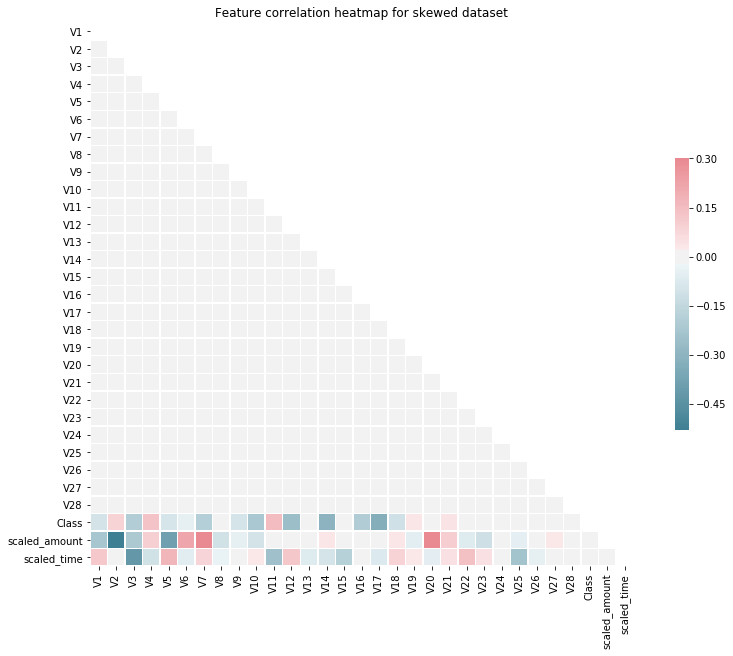

In [9]:
# generate feature correlation heatmap

def corr_heatmap(df, title=None):
    # get feature correlations
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(title)

    # Generate colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    hm = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
corr_heatmap(df, 'Feature correlation heatmap for skewed dataset')

# Data analysis

## Balancing the data by random undersampling the majority class

In [10]:
# data classes are heavily skewed, so this is more outlier/anomaly detection rather than classification

# one method to deal with skewed classes is to undersample the majority class; shuffle data and undersample normal class
df = df.sample(frac=1, random_state=42)
normal = df.loc[df['Class'] == 1]
fraud = df.loc[df['Class'] == 0][:len(normal)]

# concatenate undersampled data into new dataframe
df_us_concat = pd.concat([normal, fraud])
# shuffle undersampled df
df_us = df_us_concat.sample(frac=1, random_state=42)

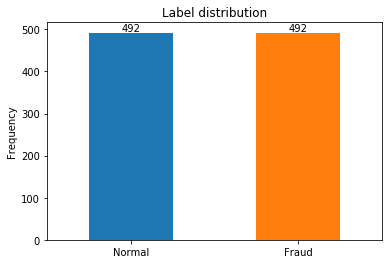

In [11]:
# check undersampled distribution
df_count_classes_plot(df_us)

### Heatmap of feature correlations for undersampled data

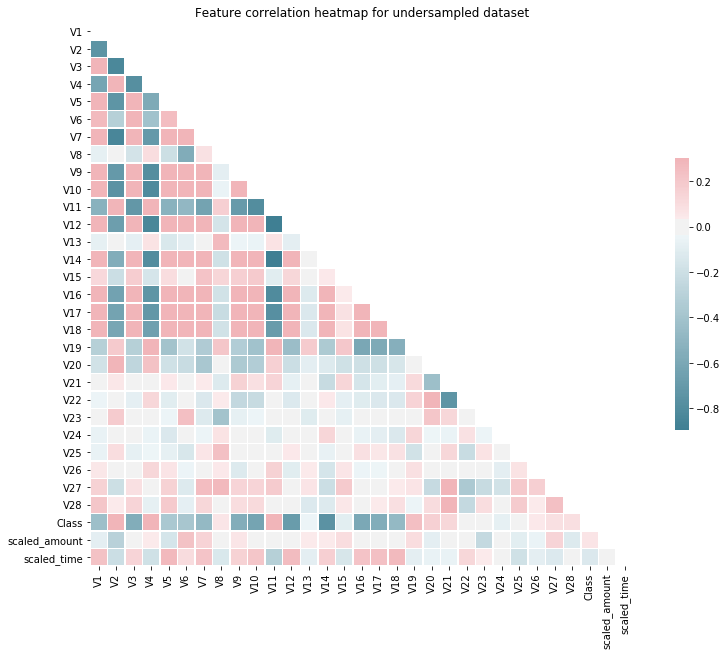

In [12]:
# check the correlation heatmap again, now that the classes are balanced
corr_heatmap(df_us, 'Feature correlation heatmap for undersampled dataset')

### t-SNE for dimensionality reduction and visualization

In [13]:
# define function for plotting t-SNE for visualization using dimensionality reduction

def tsne_plot(x1, y1, title=None):
    tsne = TSNE(n_components=2, random_state=42)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color=colors[0], alpha=0.5, label='Normal')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color=colors[1], alpha=0.5, label='Fraud')

    plt.suptitle(title, y=0.92)
    plt.xlabel('dimension 1')
    plt.ylabel('dimension 2')
    plt.legend(loc='best')
    plt.show()

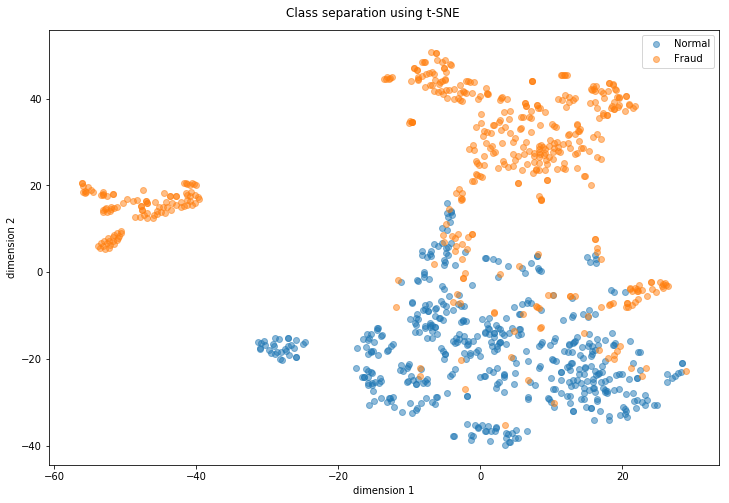

In [14]:
# visualize the undersampled data after applying t-SNE for dimensionality reduction

X_rus = df_us.drop(['Class'], axis=1)
y_rus = df_us['Class']

tsne_plot(X_rus, y_rus, 'Class separation using t-SNE')

### Autoencoding neural network for dimensionality reduction

In [24]:
# set up an autoencoder model to compress model features and possibly improve class separation

def build_model(X):
    # input layer 
    input_layer = Input(shape=(X.shape[1],))
    # encoder
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(20, activation='relu')(encoded)
    # decoder
    decoded = Dense(20, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)
    # output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)

    # compile model
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    
    return autoencoder

In [16]:
# scale the undersampled training data

def scale_data(xdata,ydata):
    X_scale = MinMaxScaler().fit_transform(xdata)
    X_norm, X_fraud = X_scale[ydata == 0], X_scale[ydata == 1]
    
    return X_norm, X_fraud

In [17]:
# fit the autoencoder model and get latent representations

def fit_model(autoencoder, X_norm):
    autoencoder.fit(X_norm, X_norm, 
                    batch_size = 256, epochs = 10, 
                    shuffle = True, validation_split = 0.2, verbose=0)

In [18]:
# get hidden representation from autoencoder model

def get_hidden(X_norm, X_fraud):
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])

    # get hidden representations of the two data classes
    norm_hid_rep = hidden_representation.predict(X_norm)
    fraud_hid_rep = hidden_representation.predict(X_fraud)
    
    return norm_hid_rep, fraud_hid_rep

In [19]:
# now visualize the two classes after being encoded

def plot_compressed_data(norm_hid_rep, fraud_hid_rep, title=None):
    rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
    y_n = np.zeros(norm_hid_rep.shape[0])
    y_f = np.ones(fraud_hid_rep.shape[0])
    rep_y = np.append(y_n, y_f)
    tsne_plot(rep_x, rep_y, title)

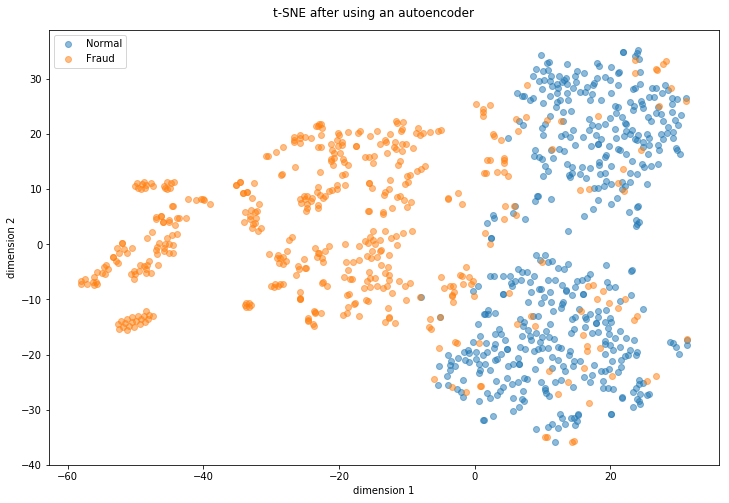

In [25]:
# fit autoencoder using undersampled data

autoencoder = build_model(X_rus)
X_norm, X_fraud = scale_data(X_rus, y_rus)
fit_model(autoencoder, X_norm)

# use hidden layer of model to generate data with 'compressed' features
norm_hid_rep, fraud_hid_rep = get_hidden(X_norm, X_fraud)

# concatenate hidden representation predictions for normal and fraud samples
X_hid_rep = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_norm = np.zeros(norm_hid_rep.shape[0])
y_fraud = np.ones(fraud_hid_rep.shape[0])
y_hid_rep = np.append(y_norm, y_fraud)

# plot t-SNE using encoded representations
X_t = tsne_plot(X_hid_rep, y_hid_rep, 't-SNE after using an autoencoder')

In [ ]:
# class separation with the autoencoder is not much better (perhaps worse) than just t-SNE,
# but we can see another division in the data, within the classes. This does not seem to
# correspond to any of the features, but I will revisit it in the future.

### PCA for dimensionality reduction

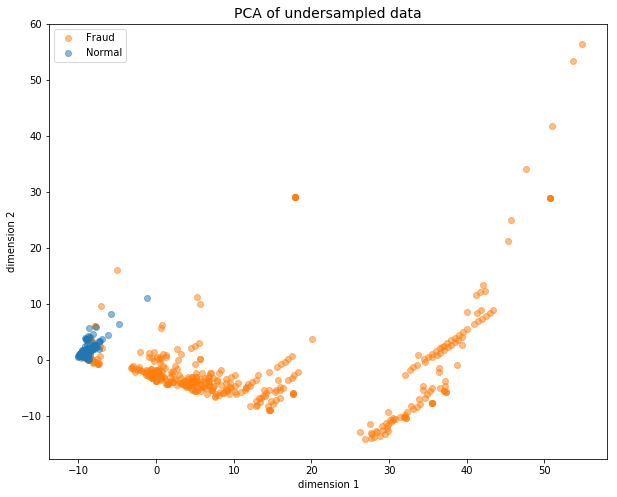

In [26]:
# Another dimensionality reduction method to try is PCA

# compute principle components
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_rus.values)

# plot reduced data
figure, ax = plt.subplots(figsize=(10,8))

plt.scatter(X_pca[np.where(y_rus == 1), 0], X_pca[np.where(y_rus == 1), 1], marker='o', color=colors[1], alpha=0.5, label='Fraud')
plt.scatter(X_pca[np.where(y_rus == 0), 0], X_pca[np.where(y_rus == 0), 1], marker='o', color=colors[0], alpha=0.5, label='Normal')

ax.set_title('PCA of undersampled data', fontsize=14)
xlabel = plt.xlabel('dimension 1')
ylabel = plt.ylabel('dimension 2')
legend = ax.legend(loc='best')

### Fitting the undersampled data using logistic regression

In [29]:
# separate the random undersampled data (rus) into classes using logistic regression

# split data into training and testing sets
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)

# fit log reg model, predict classes, and score model
clf = LogisticRegression(solver='liblinear').fit(X_train_rus, y_train_rus)
training_score = cross_val_score(clf, X_train_rus, y_train_rus, cv=5)
y_pred_rus = clf.predict(X_test_rus)

print ("")
print ("Classification Report: ")
print (classification_report(y_test_rus, y_pred_rus))

#print ("")
#print ("Accuracy Score: {:.3f}".format(accuracy_score(y_test_rus, y_pred_rus)))

print ("")
print ("Cross Validation Accuracy: {:.3f}".format(training_score.mean()))


Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.94      0.91        87
           1       0.95      0.89      0.92       110

   micro avg       0.91      0.91      0.91       197
   macro avg       0.91      0.92      0.91       197
weighted avg       0.92      0.91      0.91       197


Cross Validation Accuracy: 0.947


### Plotting the learning curve

In [ ]:
# function modified from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(clf, title, X_rus, y_rus, ylim=(0.85, 1.0) cv=cv, n_jobs=4)

plt.show()

Future work includes plotting the learning curves, ROC, precision-recall, and the confusion matrix.

Then I will implement models using Keras.